In [157]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
base_d_results = pd.read_excel("datasets/Dynamic_BG_results.xlsx", "Dynamic_BG", header=None)

def gersdemo_prepare_results(results_df):
    results_df = results_df.T
    results_df = results_df.fillna(0)
    results_df.columns = results_df.iloc[0]
    results_df = results_df[1:]
    results_df.reset_index(drop=True, inplace=True)
    return results_df

def gersdemo_prod_results(results_df, clean=True):
    # Results setup. Done to create a cleaned dataframe that puts the columns as the attributes and years, and that changes all NA values to 0, since the model outputs no production as NA.
    if clean:
        results_df = gersdemo_prepare_results(results_df)
    
    # An output dataframe which includes the year and production for coal, gas, and oil. Done to allow for easier summation mathematics.
    output_df = pd.DataFrame(columns=["Year", "Coal Prod", "Gas Prod", "Oil Prod"])
    
    # Finding the first numeric column in the dataset, then getting its location. This is done to ensure that, if a change was made to the dataframe, the code would still start at the first year of production XXXX.
    first_numeric_col = results_df.apply(pd.to_numeric, errors='coerce').notna().any().idxmax()
    first_col_index = results_df.columns.get_loc(first_numeric_col)
    years = results_df.columns[first_col_index:]
    
    coal_data = results_df[results_df['mineral'] == 'Coal']
    gas_data = results_df[results_df['mineral'] == 'Gas']
    oil_data = results_df[results_df['mineral'] == 'Oil']
    
    # Loops through each year in the total model years, creates a year dataframe, and then concats that onto the output dataframe. This is done to allow for easy summation per year, where each year is the sum of it and the previous years production.
    for i, year in enumerate(years):
        i_adj = i + first_col_index
        
        year_prod = pd.DataFrame.from_dict({
            "Year": [int(year)],
            "Coal Prod": [coal_data.iloc[:, i_adj].sum()],
            "Gas Prod": [gas_data.iloc[:, i_adj].sum()],
            "Oil Prod": [oil_data.iloc[:, i_adj].sum()]
        })
        output_df = pd.concat([output_df, year_prod], ignore_index=True)
    
    return output_df

def gersdemo_summed_results(results_df):
    # Results setup. Done to create a cleaned dataframe that puts the columns as the attributes and years, and that changes all NA values to 0, since the model outputs no production as NA.
    results_df = gersdemo_prepare_results(results_df)
    
    # An output dataframe which includes the year and production for coal, gas, and oil. Done to allow for easier summation mathematics.
    output_df = pd.DataFrame(columns=["Year", "Coal Sum Prod", "Gas Sum Prod", "Oil Sum Prod"])
    
    # Finding the first numeric column in the dataset, then getting its location. This is done to ensure that, if a change was made to the dataframe, the code would still start at the first year of production XXXX.
    first_numeric_col = results_df.apply(pd.to_numeric, errors='coerce').notna().any().idxmax()
    first_col_index = results_df.columns.get_loc(first_numeric_col)
    years = results_df.columns[first_col_index:]
    
    # Initializing cumulative sums and dataframes for Coal, Gas, and Oil, since there three need to be seperated before column summation.
    coal_cumsum = 0
    gas_cumsum = 0
    oil_cumsum = 0
    
    coal_data = results_df[results_df['mineral'] == 'Coal']
    gas_data = results_df[results_df['mineral'] == 'Gas']
    oil_data = results_df[results_df['mineral'] == 'Oil']
    
    # Loops through each year in the total model years, creates a year dataframe, and then concats that onto the output dataframe. This is done to allow for easy summation per year, where each year is the sum of it and the previous years production.
    for i, year in enumerate(years):
        i_adj = i + first_col_index
        coal_cumsum += coal_data.iloc[:, i_adj].sum()
        gas_cumsum += gas_data.iloc[:, i_adj].sum()
        oil_cumsum += oil_data.iloc[:, i_adj].sum()
        
        year_prod = pd.DataFrame.from_dict({
            "Year": [int(year)],
            "Coal Sum Prod": [coal_cumsum],
            "Gas Sum Prod": [gas_cumsum],
            "Oil Sum Prod": [oil_cumsum]
        })
        output_df = pd.concat([output_df, year_prod], ignore_index=True)
    
    return output_df


# base_d_sum_prod = gersdemo_summed_results(base_d_results)
base_d_sum_prod_nonsum = gersdemo_prod_results(base_d_results)
cleaned_base_dataset = gersdemo_prepare_results(base_d_results)
# display(base_d_sum_prod_nonsum)

In [81]:
# output_df = pd.DataFrame(columns=["Year", "Coal p", "Gas p", "Oil p"])
# coal_sum = base_d_sum_prod["Coal Prod"].sum()
# oil_sum = base_d_sum_prod["Oil Prod"].sum()
# gas_sum = base_d_sum_prod["Gas Prod"].sum()
# 
# print(base_d_sum_prod.loc[base_d_sum_prod["Year"]==1714])

def exploitation_ratio_adjusted(prod_df):
    """An estimate of the exploitation ratio of a fossil fuel calculated by and based on Court and Fizaine's historical
    data. This follows a logistical growth/sigmoid function, and is used in the theoretical predictions of EROI."""
    output_df = pd.DataFrame(columns=["Year", "Coal p", "Gas p", "Oil p"])

    def _exploitation_ratio_eq(year, resource_type):
        try:
            cur_year_sum_prod = float(prod_df.loc[base_d_sum_prod["Year"]==year-1][resource_type + " Sum Prod"])
        except Exception as e:
            # Done since the first loc command would not exist and the result should be 0.
            cur_year_sum_prod = 0
        total_sum = prod_df[resource_type + " Sum Prod"].iloc[-1]
        return cur_year_sum_prod/total_sum

    for i in range(len(prod_df.index)):
        cur_year = prod_df["Year"][i]
        year_exploitation_ratio = pd.DataFrame.from_dict({
            "Year": [cur_year],
            "Coal p": [_exploitation_ratio_eq(cur_year, "Coal")],
            "Gas p": [_exploitation_ratio_eq(cur_year, "Gas")],
            "Oil p": [_exploitation_ratio_eq(cur_year, "Oil")]
        })
        output_df = pd.concat([output_df, year_exploitation_ratio], ignore_index=True)
    return output_df

base_d_expl_ratio = exploitation_ratio_adjusted(base_d_sum_prod)
display(base_d_expl_ratio)

,Year,Coal p,Gas p,Oil p
0,1710,0.000000e+00,0.0,0.0
1,1711,1.673641e-09,0.0,0.0
2,1712,1.506273e-08,0.0,0.0
3,1713,4.351460e-08,0.0,0.0
4,1714,9.707097e-08,0.0,0.0
...,...,...,...,...
691,2401,1.000000e+00,1.0,1.0
692,2402,1.000000e+00,1.0,1.0
693,2403,1.000000e+00,1.0,1.0
694,2404,1.000000e+00,1.0,1.0


In [82]:
from Dependencies import constants as c
import numpy as np

def resource_fossil_EROI(expl_ratio_df):
    output_df = pd.DataFrame(columns=["Year", "Coal EROI", "Gas EROI", "Oil EROI"])
    coal_resource_dict = getattr(c, "Coal")
    oil_resource_dict = getattr(c, "Oil")
    gas_resource_dict = getattr(c, "Gas")

    def _resource_fossil_EROI_eq(resource_er_value, resource_dict):
        return ((resource_dict["in"] +
                 ((1 - resource_dict["in"]) / (
                          1 + np.exp(
                      -resource_dict["tl"] * (resource_er_value - resource_dict["me"]))))) *
                 np.exp(-resource_dict["rd"] * resource_er_value) *
                resource_dict["sf"])

    for i in range(len(expl_ratio_df.index)):
        cur_year = expl_ratio_df["Year"][i]
        year_exploitation_ratio = pd.DataFrame.from_dict({
            "Year": [cur_year],
            "Coal EROI": [_resource_fossil_EROI_eq(expl_ratio_df["Coal p"][i], coal_resource_dict)],
            "Gas EROI": [_resource_fossil_EROI_eq(expl_ratio_df["Gas p"][i], gas_resource_dict)],
            "Oil EROI": [_resource_fossil_EROI_eq(expl_ratio_df["Oil p"][i], oil_resource_dict)]
        })
        output_df = pd.concat([output_df, year_exploitation_ratio], ignore_index=True)
    return output_df

base_d_EROI = resource_fossil_EROI(base_d_expl_ratio)
display(base_d_EROI)

,Year,Coal EROI,Gas EROI,Oil EROI
0,1710,17.566720,31.135738,18.732729
1,1711,17.566721,31.135738,18.732729
2,1712,17.566724,31.135738,18.732729
3,1713,17.566732,31.135738,18.732729
4,1714,17.566747,31.135738,18.732729
...,...,...,...,...
691,2401,1.000011,1.000036,1.000035
692,2402,1.000011,1.000036,1.000035
693,2403,1.000011,1.000036,1.000035
694,2404,1.000011,1.000036,1.000035


In [158]:
def net_energy_results(results_df, EROI_results):
    

    first_numeric_col = results_df.apply(pd.to_numeric, errors='coerce').notna().any().idxmax()
    first_col_index = results_df.columns.get_loc(first_numeric_col)
    years = results_df.columns[first_col_index:]
    
    def _get_resource_dataframe(resource):
        resource_data = results_df[results_df['mineral'] == resource]
        for i, year in enumerate(years):
            i_adj = i + first_col_index
            resource_eroi_value = EROI_results.loc[EROI_results['Year'] == int(year), resource + ' EROI'].iloc[0]
            resource_data.iloc[:, i_adj] = resource_data.iloc[:, i_adj] * (1-1/resource_eroi_value)
        return resource_data
    
    net_energy_df = pd.concat([_get_resource_dataframe("Coal"), _get_resource_dataframe("Gas"), _get_resource_dataframe("Oil")], ignore_index=True)
    
    return net_energy_df

base_d_net_en = net_energy_results(cleaned_base_dataset, base_d_EROI)
base_d_prod_net_en = gersdemo_prod_results(base_d_net_en, clean=False)


In [159]:

base_d_results = pd.read_excel("datasets/Dynamic_BG_results.xlsx", "Dynamic_BG", header=None)
base_d_sum_prod = gersdemo_summed_results(base_d_results)
base_d_prod = gersdemo_prod_results(base_d_results)
base_d_expl_ratio = exploitation_ratio_adjusted(base_d_sum_prod)
base_d_EROI = resource_fossil_EROI(base_d_expl_ratio)

cleaned_base_df = gersdemo_prepare_results(base_d_results)
base_d_net_en = net_energy_results(cleaned_base_df, base_d_EROI)
base_d_prod_net_en = gersdemo_prod_results(base_d_net_en, clean=False)

print("Base EROI completed")

high_d_results = pd.read_excel("datasets/Dynamic_High_results.xlsx", "Dynamic_High", header=None)
high_d_sum_prod = gersdemo_summed_results(high_d_results)
high_d_prod = gersdemo_prod_results(high_d_results)
high_d_expl_ratio = exploitation_ratio_adjusted(high_d_sum_prod)
high_d_EROI = resource_fossil_EROI(high_d_expl_ratio)

print("High EROI completed")

low_d_results = pd.read_excel("datasets/Dynamic_Low_results.xlsx", "Dynamic_Low", header=None)
low_d_sum_prod = gersdemo_summed_results(low_d_results)
low_d_prod = gersdemo_prod_results(low_d_results)
low_d_expl_ratio = exploitation_ratio_adjusted(low_d_sum_prod)
low_d_EROI = resource_fossil_EROI(low_d_expl_ratio)

print("Low EROI completed")


print("Finished running base, low, high EROI")



Base EROI completed
High EROI completed
Low EROI completed
Finished running base, low, high EROI


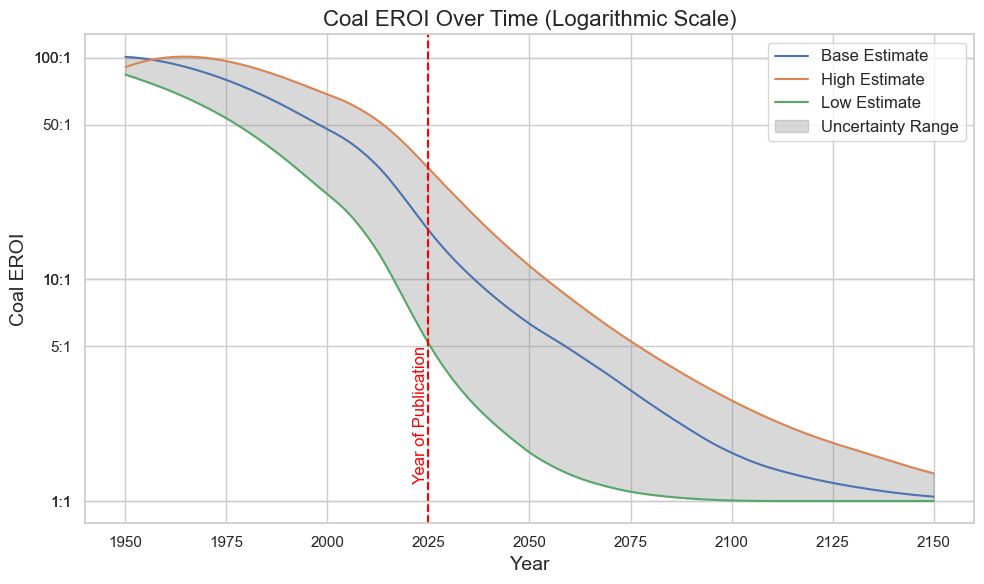

In [124]:
from matplotlib.ticker import FuncFormatter, MultipleLocator, LogLocator


# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Interpolation for smoothness
x_interp = np.linspace(1950, 2150, 500)
y_interp_coal_b = np.interp(x_interp, base_d_EROI['Year'], base_d_EROI['Coal EROI'])
y_interp_coal_h = np.interp(x_interp, high_d_EROI['Year'], high_d_EROI['Coal EROI'])
y_interp_coal_l = np.interp(x_interp, low_d_EROI['Year'], low_d_EROI['Coal EROI'])
plt.yscale('log')

formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks

# Double the ticks on the y-axis
ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))

# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_coal_b, label="Base Estimate")
sns.lineplot(x=x_interp, y=y_interp_coal_h, label="High Estimate")
sns.lineplot(x=x_interp, y=y_interp_coal_l, label="Low Estimate")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_coal_b, y_interp_coal_l, y_interp_coal_h])
y_upper = np.maximum.reduce([y_interp_coal_b, y_interp_coal_l, y_interp_coal_h])

# Add a single uncertainty shading region
plt.fill_between(
    x_interp, y_lower, y_upper, 
    color='gray', alpha=0.3, label="Uncertainty Range"
)

# Add a vertical line for 2024
plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
plt.text(2025 - 2, plt.gca().get_ylim()[0] * 1.5, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Coal EROI Over Time (Logarithmic Scale)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Coal EROI", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/CoalEROIOverTime.png')
plt.show()

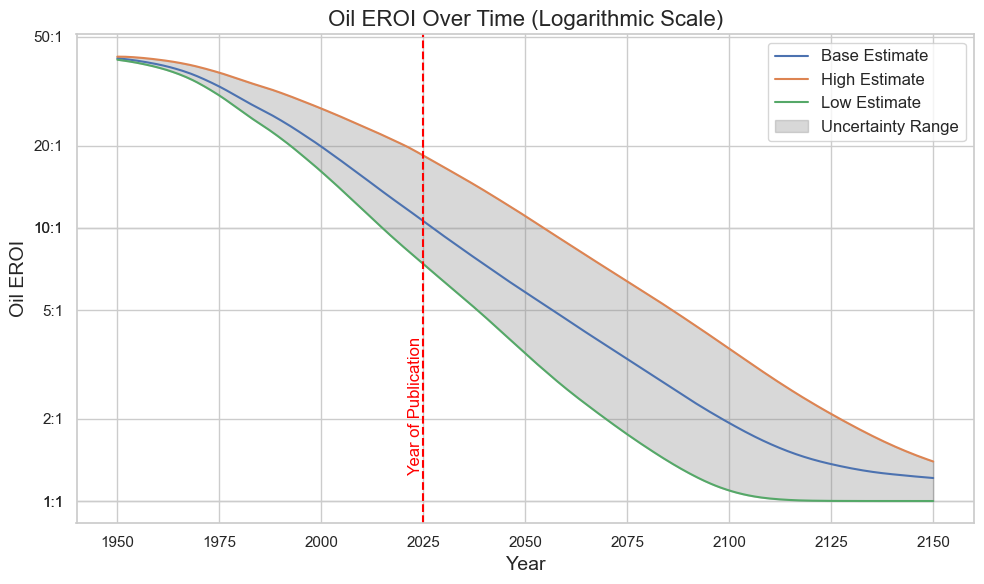

In [121]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Interpolation for smoothness
x_interp = np.linspace(1950, 2150, 500)
y_interp_Oil_b = np.interp(x_interp, base_d_EROI['Year'], base_d_EROI['Oil EROI'])
y_interp_Oil_h = np.interp(x_interp, high_d_EROI['Year'], high_d_EROI['Oil EROI'])
y_interp_Oil_l = np.interp(x_interp, low_d_EROI['Year'], low_d_EROI['Oil EROI'])
plt.yscale('log')

formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks

# Double the ticks on the y-axis
ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 2, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_Oil_b, label="Base Estimate")
sns.lineplot(x=x_interp, y=y_interp_Oil_h, label="High Estimate")
sns.lineplot(x=x_interp, y=y_interp_Oil_l, label="Low Estimate")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_Oil_b, y_interp_Oil_l, y_interp_Oil_h])
y_upper = np.maximum.reduce([y_interp_Oil_b, y_interp_Oil_l, y_interp_Oil_h])

# Add a single uncertainty shading region
plt.fill_between(
    x_interp, y_lower, y_upper, 
    color='gray', alpha=0.3, label="Uncertainty Range"
)

# Add a vertical line for 2024
plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
plt.text(2025 - 2, plt.gca().get_ylim()[0] * 1.5, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Oil EROI Over Time (Logarithmic Scale)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Oil EROI", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/OilEROIOverTime.png')
plt.show()

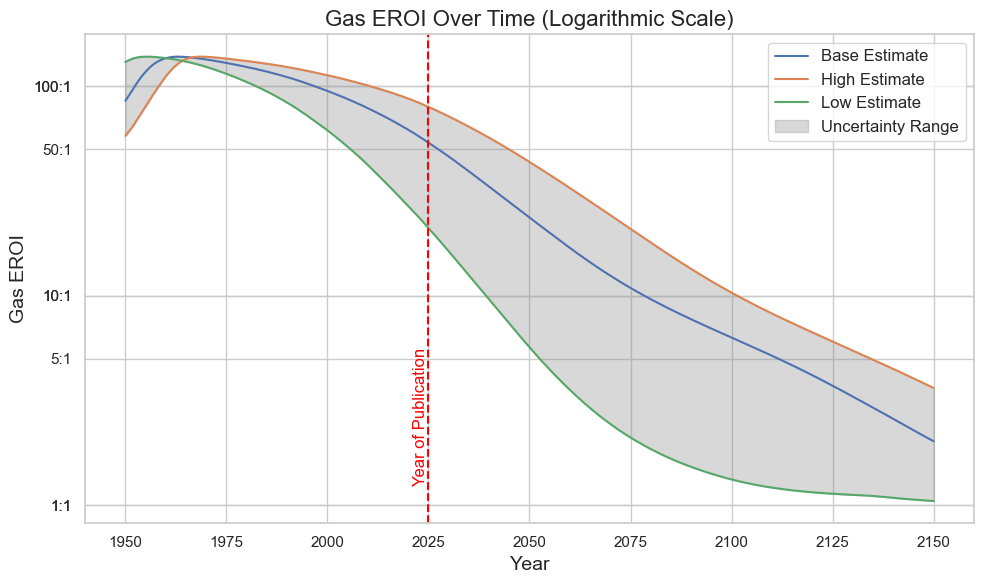

In [118]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Interpolation for smoothness
x_interp = np.linspace(1950, 2150, 500)
y_interp_Gas_b = np.interp(x_interp, base_d_EROI['Year'], base_d_EROI['Gas EROI'])
y_interp_Gas_h = np.interp(x_interp, high_d_EROI['Year'], high_d_EROI['Gas EROI'])
y_interp_Gas_l = np.interp(x_interp, low_d_EROI['Year'], low_d_EROI['Gas EROI'])
plt.yscale('log')

formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks

# Double the ticks on the y-axis
ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_Gas_b, label="Base Estimate")
sns.lineplot(x=x_interp, y=y_interp_Gas_h, label="High Estimate")
sns.lineplot(x=x_interp, y=y_interp_Gas_l, label="Low Estimate")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_Gas_b, y_interp_Gas_l, y_interp_Gas_h])
y_upper = np.maximum.reduce([y_interp_Gas_b, y_interp_Gas_l, y_interp_Gas_h])

# Add a single uncertainty shading region
plt.fill_between(
    x_interp, y_lower, y_upper, 
    color='gray', alpha=0.3, label="Uncertainty Range"
)

# Add a vertical line for 2024
plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
plt.text(2025 - 2, plt.gca().get_ylim()[0] * 1.5, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Gas EROI Over Time (Logarithmic Scale)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Gas EROI", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/GasEROIOverTime.png')
plt.show()

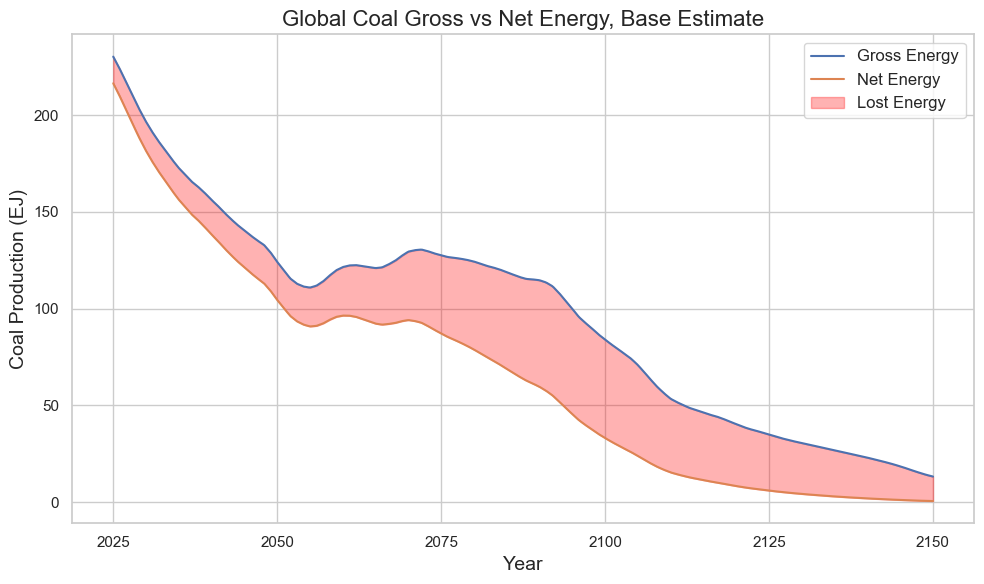

In [161]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Interpolation for smoothness
x_interp = np.linspace(2025, 2150, 500)
y_interp_gross = np.interp(x_interp, base_d_prod['Year'], base_d_prod['Coal Prod'])
y_interp_net = np.interp(x_interp, base_d_prod_net_en['Year'], base_d_prod_net_en['Coal Prod'])

# formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
# plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks

# Double the ticks on the y-axis
# ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_gross, label="Gross Energy")
sns.lineplot(x=x_interp, y=y_interp_net, label="Net Energy")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_gross, y_interp_net])
y_upper = np.maximum.reduce([y_interp_gross, y_interp_net])

# Add a single uncertainty shading region
plt.fill_between(
    x_interp, y_lower, y_upper, 
    color='red', alpha=0.3, label="Lost Energy"
)

# # Add a vertical line for 2024
# plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
# plt.text(2025 - 2, plt.gca().get_ylim()[0] * 1.5, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Global Coal Gross vs Net Energy, Base Estimate", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Coal Production (EJ)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/GlobalCoalProductionGrossVsNet.png')
plt.show()

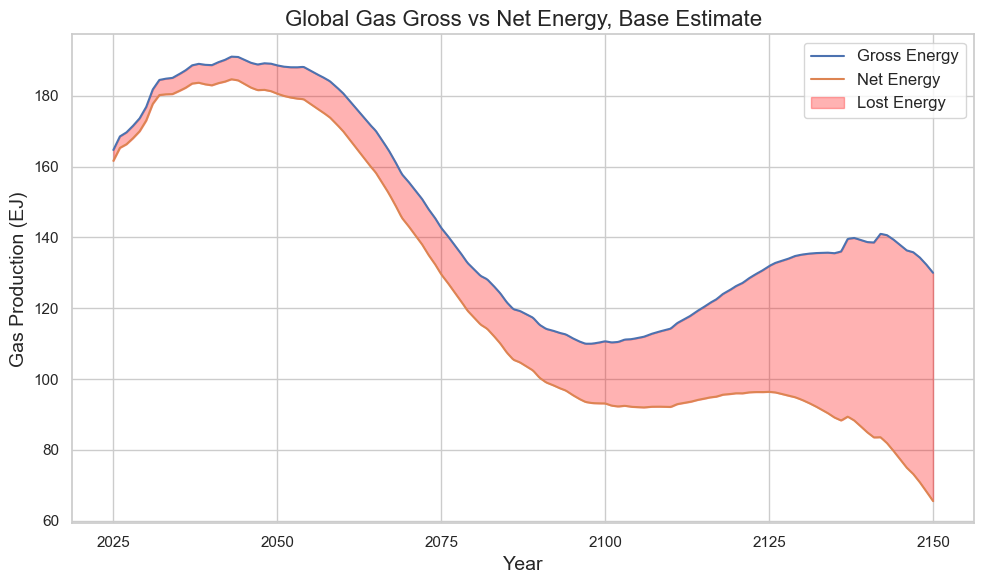

In [162]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Interpolation for smoothness
x_interp = np.linspace(2025, 2150, 500)
y_interp_gross = np.interp(x_interp, base_d_prod['Year'], base_d_prod['Gas Prod'])
y_interp_net = np.interp(x_interp, base_d_prod_net_en['Year'], base_d_prod_net_en['Gas Prod'])

# formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
# plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks

# Double the ticks on the y-axis
# ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_gross, label="Gross Energy")
sns.lineplot(x=x_interp, y=y_interp_net, label="Net Energy")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_gross, y_interp_net])
y_upper = np.maximum.reduce([y_interp_gross, y_interp_net])

# Add a single uncertainty shading region
plt.fill_between(
    x_interp, y_lower, y_upper, 
    color='red', alpha=0.3, label="Lost Energy"
)

# # Add a vertical line for 2024
# plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
# plt.text(2025 - 2, plt.gca().get_ylim()[0] * 1.5, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Global Gas Gross vs Net Energy, Base Estimate", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Gas Production (EJ)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/GlobalGasProductionGrossVsNet.png')
plt.show()

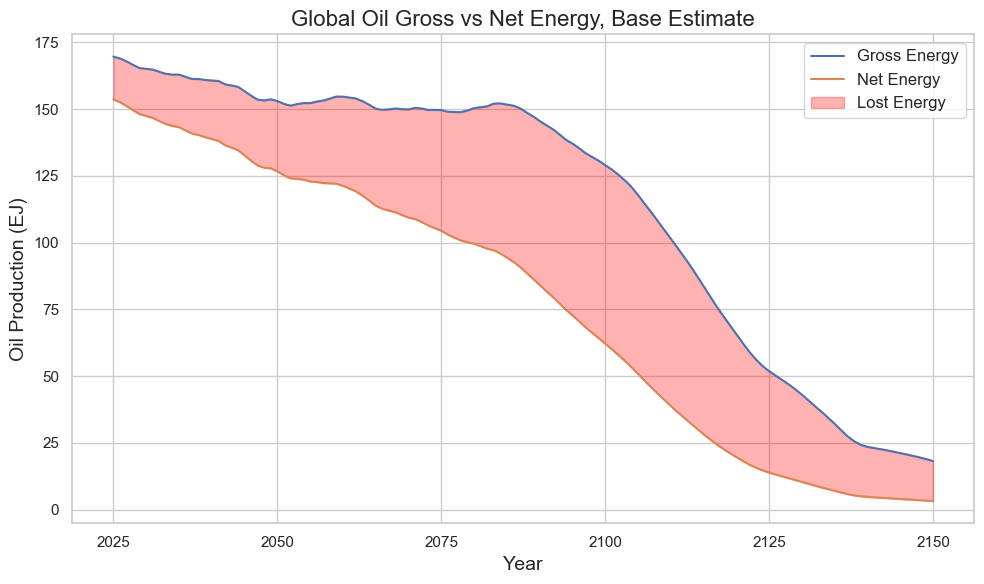

In [163]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Interpolation for smoothness
x_interp = np.linspace(2025, 2150, 500)
y_interp_gross = np.interp(x_interp, base_d_prod['Year'], base_d_prod['Oil Prod'])
y_interp_net = np.interp(x_interp, base_d_prod_net_en['Year'], base_d_prod_net_en['Oil Prod'])

# formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
# plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks

# Double the ticks on the y-axis
# ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_gross, label="Gross Energy")
sns.lineplot(x=x_interp, y=y_interp_net, label="Net Energy")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_gross, y_interp_net])
y_upper = np.maximum.reduce([y_interp_gross, y_interp_net])

# Add a single uncertainty shading region
plt.fill_between(
    x_interp, y_lower, y_upper, 
    color='red', alpha=0.3, label="Lost Energy"
)

# # Add a vertical line for 2024
# plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
# plt.text(2025 - 2, plt.gca().get_ylim()[0] * 1.5, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Global Oil Gross vs Net Energy, Base Estimate", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Oil Production (EJ)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/GlobalOilProductionGrossVsNet.png')
plt.show()